<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_PG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [313]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [314]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-s8hlfbt3
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-s8hlfbt3
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0dfd9739e4bdcce166dc6326afcde41af9a5f8641_-cp36-none-any.whl size=119874 sha256=5798488ffe355a9b7af6e826485d0798a63a83a9dd1e526996fcb99d163da912
  Stored in directory: /tmp/pip-ephem-wheel-cache-zd6iqcmn/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [315]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [316]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [485]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/PG/df_PG_20drtn_features.csv')

In [486]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,53.348952,44.243367,57.782541,36.750266,-54.863665,-54.863665,-44.200574,-65.285437,28.789543,26.419908,40.593401,29.852807,-0.284850,0.241151,-0.686873,0.833843,1.837398,0.009626,-0.089517,-0.157775,-0.135129,-0.281755,-0.281755,-0.281755,-0.281755,65.987062,-0.411113,14.315831,40.546795,-10.491695,-23.050681,0.333338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131158,0.022687,0.136018,-0.005893,0.173834,-0.000163,27.549999,2.949999,4.019999,-2.285469e+05,-2.285469e+05,-2.285469e+05,-2.285469e+05,0.193752,0.064862,0.078150,-0.093329,-0.148497,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,47.754366,40.152946,52.298269,35.080573,-88.702747,-82.490092,-66.457635,-69.732915,28.190778,26.032606,34.125625,30.000227,-1.067507,-0.378501,-0.574187,-0.619236,0.045623,0.002329,-0.082910,-0.150101,-0.135352,-0.317805,-0.317805,-0.317805,-0.317805,-67.600180,-110.107742,-93.237187,-46.692259,-9.046785,-21.015811,0.194038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141785,0.020584,0.139966,-0.008725,0.175141,0.002539,27.490000,-0.059999,0.949999,-3.407450e+06,-3.407450e+06,-3.407450e+06,-3.407450e+06,0.064651,0.040137,0.036221,-0.098819,0.381205,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,45.486662,42.693140,49.935585,35.259290,-90.376426,-84.046548,-67.711585,-68.410042,18.354803,25.764534,33.474010,30.033482,-0.060792,-1.409288,-0.889218,-1.379721,1.138120,-0.008297,-0.078519,-0.143440,-0.135511,-0.345619,-0.345619,-0.345619,-0.345619,-79.322513,-105.882223,-106.106162,-67.952973,-7.384152,-18.730014,0.529418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135217,0.015619,0.133328,-0.011756,0.175155,0.002225,29.379999,1.889999,3.099998,-2.455292e+06,-2.455292e+06,-2.455292e+06,-2.455292e+06,0.059267,0.082835,0.063239,-0.098417,0.001469,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,50.719458,53.212216,58.800006,37.853776,-46.445282,-49.027029,-49.027029,-51.901803,20.100475,32.864859,34.566178,33.005250,1.368615,0.225532,0.923544,-1.507087,1.000006,-0.011633,-0.073026,-0.136433,-0.135452,-0.291677,-0.291677,-0.291677,-0.291677,29.089912,2.774800,2.367415,17.818806,-6.131620,-16.386790,0.904259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130868,0.009046,0.131409,-0.014566,0.162606,-0.010365,26.360001,-3.019999,0.840000,2.613996e+06,2.613996e+06,2.613996e+06,2.613996e+06,0.086144,0.170367,0.068866,-0.048378,0.028706,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,43.877994,55.457204,55.915196,42.862985,-28.095084,-34.241142,-34.241142,-46.583855,28.136698,38.318389,34.172469,35.128841,0.570053,1.884495,0.509751,-0.252936,-0.178682,-0.007180,-0.065776,-0.128745,-0.135127,-0.215777,-0.215777,-0.215777,-0.215777,122.411025,137.642678,100.034693,102.122294,-4.874126,-13.796205,0.404043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131496,0.000070,0.116943,-0.018754,0.163395,-0.010840,27.219999,0.859999,2.619999,2.963874e+06,2.963874e+06,2.963874e+06,2.963874e+06,0.106878,0.114340,0.032101,-0.043119,-0.319581,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [487]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [488]:
from_date='2010-01-01'
to_date='2020-01-01'

In [489]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [400]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,71.393632,63.202470,61.326716,64.766705,-47.787727,-27.979318,-24.000041,-16.363668,77.823898,72.822326,70.628810,68.679806,0.032305,0.000000,-0.673728,1.976280,3.268844,0.223252,0.218912,0.244169,0.281295,0.449064,0.449064,0.449064,0.449064,-23.088105,-0.566587,49.138394,83.156463,47.209416,53.236178,0.695650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154032,-0.013830,0.163112,0.014023,0.156250,-0.005745,19.350000,-0.690001,-0.580000,1.368606e+06,1.368606e+06,1.368606e+06,1.368606e+06,0.156515,0.097234,0.088590,0.186999,0.295256,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,57.390212,60.506715,57.738107,61.947740,-71.568550,-37.823804,-32.444424,-24.579115,62.470388,64.633992,68.818138,67.816165,-0.613691,0.951447,-1.975148,0.819135,3.289693,0.209822,0.214629,0.240274,0.279987,0.418543,0.418543,0.418543,0.418543,-37.521595,-62.994555,24.392363,62.019997,45.740044,51.638385,0.446429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157851,-0.009022,0.162983,0.013721,0.157627,0.003620,19.160000,-0.190001,-0.850000,-2.772454e+06,-2.772454e+06,-2.772454e+06,-2.772454e+06,0.172051,0.050180,0.099441,0.171127,0.169505,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,48.118816,53.617997,56.211874,59.727456,-80.152646,-54.404097,-46.666633,-38.181790,50.221809,64.456586,67.669040,64.911152,-1.039973,-1.615509,-1.647281,-1.200516,2.975993,0.187078,0.206542,0.234640,0.278338,0.364333,0.364333,0.364333,0.364333,-129.128895,-177.378583,-51.318022,12.410045,43.908787,49.560908,0.509804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.158332,-0.028914,0.165536,0.019023,0.156046,-0.003518,19.059999,-0.100000,-0.900000,-7.241332e+06,-7.241332e+06,-7.241332e+06,-7.241332e+06,0.124730,0.063452,0.096636,0.141907,-0.131014,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,47.472254,57.285873,60.666944,58.712005,-64.122175,-43.523317,-43.523317,-30.545460,53.097260,64.243148,67.969036,64.685894,0.689652,-0.968990,0.590552,-0.840880,3.197579,0.164305,0.197239,0.228285,0.276467,0.334461,0.334461,0.334461,0.334461,-53.080531,-92.403785,-29.156306,29.391119,41.622846,47.046687,0.656251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162192,-0.047268,0.166269,0.010812,0.156671,-0.004871,18.129999,-0.930000,-3.550001,-1.243753e+06,-1.243753e+06,-1.243753e+06,-1.243753e+06,0.102407,0.148970,0.081095,0.157445,0.012613,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,38.495565,51.475170,54.976226,56.256261,-89.130456,-72.352882,-63.730536,-44.727256,43.835861,61.717334,61.067142,61.274701,-1.272014,-1.624959,-2.197093,-2.354837,1.339135,0.134814,0.184597,0.220218,0.274215,0.276135,0.276135,0.276135,0.276135,-89.705084,-119.552998,-110.162829,-3.647167,39.168195,44.195691,0.234375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171202,-0.022552,0.173121,0.009665,0.160499,0.001239,17.549999,-0.580000,-2.490002,-9.767265e+06,-9.767265e+06,-9.767265e+06,-9.767265e+06,-0.017613,0.143953,0.016837,0.143485,0.342933,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [401]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,84.148053,67.616351,72.208864,76.742053,-13.235311,-9.121628,-9.121628,-5.598763,73.947854,67.246908,71.132596,67.375933,1.091771,1.758356,1.863719,3.729821,5.305063,0.218965,0.212944,0.208794,0.139993,2.424918,2.424918,2.424918,2.424918,166.666667,137.466082,146.970490,207.332184,50.249866,57.284793,0.509093,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.096289,-0.017575,0.104966,0.001749,0.114492,-0.020492,12.51,0.010000,-0.120000,3.878017e+07,3.878017e+07,3.878017e+07,3.878017e+07,0.155028,0.207635,0.224972,0.196086,1.142622,0.389,0.014,0.093,0.290001,0.540001,1.0
2891,2019-12-23,80.694159,71.959191,72.644194,74.921508,-13.235311,-9.121628,-9.121628,-6.818188,74.123193,74.164938,71.306969,67.161624,0.000000,1.969300,1.208773,3.997095,5.227627,0.233038,0.217974,0.211414,0.142390,2.524014,2.524014,2.524014,2.524014,88.770057,123.907912,126.704348,181.211061,51.462775,58.693955,0.164707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092400,0.009248,0.105172,0.008513,0.114516,-0.011702,12.61,0.099999,0.469999,2.585345e+07,2.585345e+07,2.585345e+07,2.585345e+07,0.127798,0.202825,0.196091,0.166893,-0.668679,0.415,0.026,0.048,-0.029999,0.610001,1.0
2892,2019-12-27,87.696721,85.804732,70.938052,75.979955,-8.779706,-6.357720,-4.573612,-3.558482,75.319313,77.263772,67.935529,67.319483,0.182775,0.984692,2.087213,3.732708,4.359243,0.268523,0.234935,0.221122,0.149915,2.759320,2.759320,2.759320,2.759320,123.163816,109.800638,123.056812,145.845762,54.107420,61.677190,0.556394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087829,-0.011186,0.102497,0.001623,0.093192,-0.027184,13.43,0.780001,0.850000,1.356284e+07,1.356284e+07,1.356284e+07,1.356284e+07,0.072509,0.168700,0.155807,0.211714,0.268047,0.356,-0.014,-0.019,-0.669998,-0.490005,1.0
2893,2019-12-30,71.812839,76.782163,64.664950,71.099898,-33.793201,-21.258204,-15.193840,-11.821511,67.342260,72.252048,67.156009,67.837210,-0.861859,0.133430,0.114346,1.980196,4.102253,0.271431,0.238724,0.223878,0.152403,2.680318,2.680318,2.680318,2.680318,-29.625731,50.084015,78.824541,106.294180,53.560325,61.086342,0.375545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102531,0.006242,0.105459,0.000493,0.093226,-0.021266,14.82,1.389999,2.320000,1.576065e+06,1.576065e+06,1.576065e+06,1.576065e+06,-0.010940,0.113913,0.167101,0.227054,-0.112118,0.405,0.049,0.016,-0.180000,-0.680000,1.0
2894,2019-12-31,69.164817,74.183784,68.797849,74.282321,-31.896640,-20.065139,-14.341122,-11.315018,58.244782,66.824025,68.411468,68.871830,0.069802,-0.611332,0.184228,1.395228,5.449678,0.268132,0.240426,0.225771,0.154781,2.596653,2.596653,2.596653,2.596653,-79.728686,20.196461,55.187546,86.915493,53.661036,60.666869,0.946964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099504,0.007104,0.091607,-0.013565,0.093321,-0.021195,13.78,-1.040000,1.270000,1.724259e+06,1.724259e+06,1.724259e+06,1.724259e+06,0.028443,0.178597,0.228903,0.250066,0.123621,0.414,0.009,-0.001,-0.349998,-1.320000,1.0


In [490]:
df.drop(['timestamp'], inplace=True, axis=1)

In [491]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [492]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,74.885114,75.358041,62.150244,45.809117,-5.691028,-3.797453,-3.442609,-28.633589,57.459054,61.144444,50.300798,41.581635,1.104671,1.779259,2.020349,3.637650,6.486328,0.138995,-0.082438,-0.190812,-0.179187,0.134475,0.134475,0.134475,0.134475,166.666667,116.799200,121.888491,155.883957,-3.079096,-12.961246,0.774195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157410,-0.019653,0.172768,-0.038209,0.223326,0.003589,19.540001,-1.400000,-8.089998,3.846921e+06,3.846921e+06,3.846921e+06,3.846921e+06,0.174509,0.140210,0.116811,0.063084,0.011238,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,53.271038,55.561363,50.732985,58.079741,-47.142793,-47.142793,-37.930970,-34.789123,61.766616,54.775446,59.229574,61.277500,-0.894437,-1.609470,0.729171,1.595039,3.111670,0.103849,0.095368,0.111575,0.149905,0.795671,0.795671,0.795671,0.795671,-61.609133,33.762745,61.092092,82.365069,17.552927,21.139183,0.064001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146122,0.000884,0.168643,-0.016726,0.147469,0.005489,14.950000,-1.360000,-3.110000,-7.973243e+05,-7.973243e+05,-7.973243e+05,-7.973243e+05,-0.051620,-0.035874,0.070083,0.205287,-0.203936,0.096,2.384186e-07,0.030,0.129997,0.529999,1.0
898,50.167594,56.552224,55.041856,52.290560,-70.089100,-67.381908,-34.734474,-26.166645,47.408407,52.101829,52.694097,54.799818,-0.812134,0.341034,-2.309084,-0.246565,2.453313,0.146706,0.133521,0.103466,0.009979,0.519981,0.519981,0.519981,0.519981,-62.217693,-62.723021,-47.058645,39.581531,33.025603,33.191560,0.577471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171109,0.032871,0.136954,-0.008358,0.175514,0.007523,24.530001,-0.929998,-6.789999,-6.493171e+05,-6.493171e+05,-6.493171e+05,-6.493171e+05,0.184199,0.223706,0.206386,0.145562,-0.364352,2.296,-8.899999e-02,0.108,0.219994,-1.210007,0.0
765,79.522778,71.130436,69.603259,48.814544,-21.602654,-21.602654,-16.621872,-14.285679,90.705461,73.205561,70.214188,53.970522,-0.219229,-0.716733,1.158913,3.173580,4.613366,0.184730,0.053378,-0.020479,-0.042046,0.503811,0.503811,0.503811,0.503811,39.919978,79.162718,106.925539,145.736609,19.954186,14.534724,0.205129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097102,-0.004705,0.103349,-0.002549,0.118079,0.005091,15.070000,-0.760000,-1.850000,5.967830e+05,5.967830e+05,5.967830e+05,5.967830e+05,0.373193,0.175371,0.166749,0.009584,-0.047338,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,1.0
1100,58.974494,75.127771,64.877450,71.370065,-22.034074,-17.808377,-6.295450,-3.945402,71.696584,70.507113,64.610838,63.523114,0.134294,0.388934,0.539327,0.947649,3.087561,0.178960,0.199499,0.173513,0.023282,0.777402,0.777402,0.777402,0.777402,159.739904,187.633296,173.401458,82.646773,54.328397,61.609786,0.490194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049036,-0.016582,0.134709,-0.005623,0.150580,-0.007745,16.350000,1.170000,2.330000,7.120585e+05,7.120585e+05,7.120585e+05,7.120585e+05,0.137063,0.219042,0.103717,0.185404,-0.251812,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,1.0


In [493]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [494]:
train_labels.head()

1856    1.0
2747    1.0
898     0.0
765     1.0
1100    1.0
Name: labels, dtype: float64

In [495]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [496]:
get_sample_weights(train_labels)

real class weights are [1.18500605 0.86496028] [0 1]
value_counts (array([0, 1]), array([ 827, 1133]))


1856    0.864960
2747    0.864960
898     1.185006
765     0.864960
1100    0.864960
          ...   
2051    0.864960
1301    0.864960
2192    0.864960
1640    0.864960
2882    1.185006
Name: labels, Length: 1960, dtype: float64

In [497]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.18500605 0.86496028] [0 1]
value_counts (array([0, 1]), array([ 827, 1133]))


In [498]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [499]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [500]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_10',
 'rsi_15',
 'rsi_40',
 'mfi_40',
 'roc_10',
 'trix_20',
 'trix_40',
 'cci_15',
 'cci_25',
 'bb_h40',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_change_5d_20',
 'realised_vol_40',
 'realised_vol_change_5d_40',
 'vix_level',
 'curve',
 'curve_shift_5d',
 'dollarix_1d_change',
 'dollarix_5d_change')

In [501]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('mfi_10',
 'mfi_40',
 'roc_3',
 'roc_20',
 'trix_15',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_10',
 'kst_40',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'realised_vol_change_5d_40',
 'vix_level',
 'cmf_15',
 'curve',
 'curve_shift')

In [502]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,mfi_10,mfi_40,roc_3,roc_20,trix_15,trix_40,macd10,macd15,macd20,macd40,cci_10,kst_40,realised_vol_10,realised_vol_20,realised_vol_40,realised_vol_change_5d_40,vix_level,cmf_15,curve,curve_shift
445,-0.556061,0.046658,-0.280553,-0.795816,-0.217289,1.734716,-0.400387,-0.400387,-0.400387,-0.400387,-0.938535,-0.274872,-0.803397,-0.764444,-0.744638,-2.091983,0.445087,-0.349470,2.013397,-1.823117
448,-1.421433,-0.911790,-0.775126,-0.946047,-0.442557,1.599929,-0.563583,-0.563583,-0.563583,-0.563583,-1.492692,-0.605004,-0.747727,-0.889853,-0.905553,-1.326586,0.226020,0.432516,2.093196,-0.153079
452,-0.328916,-0.525989,1.432248,-0.403177,-0.609089,1.403845,-0.430270,-0.430270,-0.430270,-0.430270,1.155703,-0.785977,-0.242596,-0.923290,-1.008830,-0.250549,0.136238,1.414446,2.006838,-0.865901
469,0.964237,-0.256651,0.336647,0.525595,-0.119609,0.706421,-0.053357,-0.053357,-0.053357,-0.053357,-0.246570,-0.207964,0.570478,0.656803,-0.079213,0.690121,1.639183,-0.227485,1.836308,0.661570
470,0.538253,-0.476748,0.347739,0.173918,-0.089871,0.679328,-0.048586,-0.048586,-0.048586,-0.048586,-0.449066,-0.138709,0.583027,0.577633,-0.080158,0.662265,1.531445,-0.050786,1.902990,1.272564


In [503]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [504]:
criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [505]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.61476386, 0.38523608],
       [0.5087065 , 0.49129346],
       [0.4854957 , 0.5145043 ],
       [0.56908375, 0.43091625],
       [0.5516723 , 0.44832778],
       [0.5468366 , 0.45316336],
       [0.5169857 , 0.48301426],
       [0.52127945, 0.47872058],
       [0.5193668 , 0.48063317],
       [0.54509735, 0.45490265]], dtype=float32)

In [506]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
75/79 [===========================>..] - ETA: 0s - loss: 0.7353 - accuracy: 0.5147
Epoch: 0, accuracy:0.5159,  loss:0.7351,  val_accuracy:0.5383,  val_loss:0.6866,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7351 - accuracy: 0.5159 - val_loss: 0.6866 - val_accuracy: 0.5383
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7106 - accuracy: 0.5115 - val_loss: 0.6886 - val_accuracy: 0.5051
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5319 - val_loss: 0.6759 - val_accuracy: 0.5663
Epoch 4/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.5287 - val_loss: 0.6785 - val_accuracy: 0.5281
Epoch 5/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.5440 - val_loss: 0.6769 - val_accuracy: 0.5230
Epoch 6/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6815 - accuracy: 0.5638 - val_loss: 0.6697 - val_accur

In [476]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.366402,0.842474,0.415815,0.826531,195
196,0.368596,0.834184,0.439538,0.823980,196
197,0.362479,0.848214,0.431421,0.818878,197
198,0.379508,0.830357,0.440431,0.813776,198
199,0.356289,0.845026,0.423257,0.818878,199


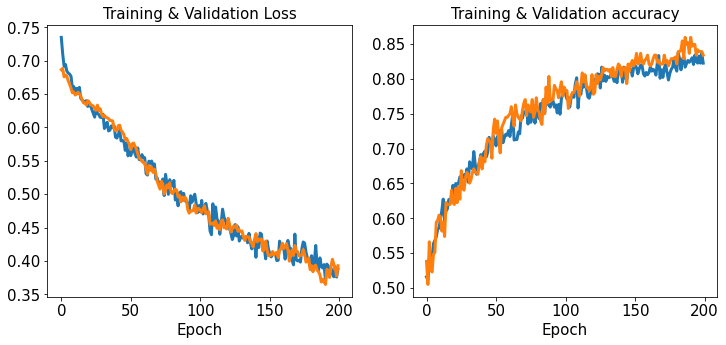

In [507]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [291]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394116 sha256=a0f86cafc8d2d87c3226574d6e57aa1e7d4381fcc214924ffcc0284d33e88ac0
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [508]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [509]:
shap_values  = explainer.shap_values(np.array(X_test_new))

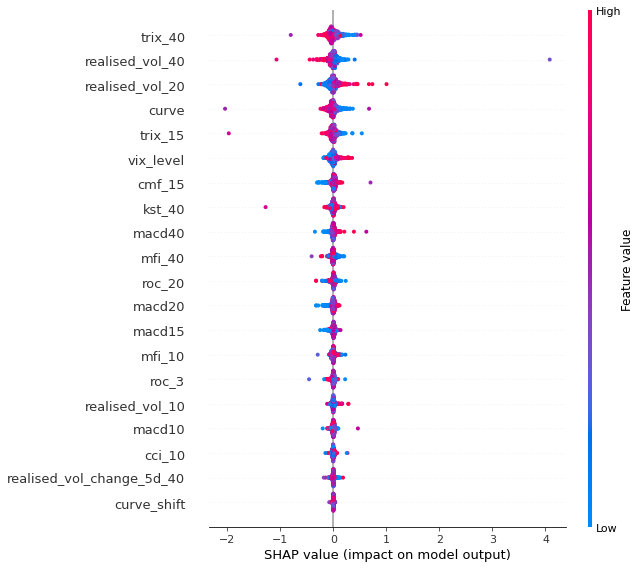

In [510]:
shap.summary_plot(shap_values[1], X_test_new)

In [511]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [512]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


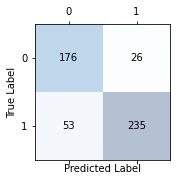

In [513]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [514]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.900
Recall: 0.816
F1: 0.856
